The idea is to model the impact of fishing quotas on a fish population, while taking into account food availability

Import all useful libraries

In [1]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import copy 
import random
import pandas as pd
from tqdm import tqdm
from scipy.stats import binom
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng()

Import the q-learning function

In [ ]:
#from robust_q_learning_v3 import *
#from q_learning_v2 import *

In [3]:
from robust_q_learning_v2 import *
from q_learning import *

First simplified case: one species, two size class

In [4]:
X = np.array([(0,0), (0,5), (5,0), (5,5)]) # States
A = np.array([0, 5]) # Actions

c1 = 1 / 5

def r(x,a,y):
    x1, x2 = x
    y1, y2 = y
    return(c1 * (x2 - a >= 0) * a - 10 * (x2 - a < 0)) # Reward function

rr = 1
dr = 0
gr = 1
npp = 0
def P(x,a):
    unif      = np.random.uniform(0)
    if (unif > eps_greedy):
        x1, x2 = x
        x2_ = max(x2 - a, 0)
        y1  = min(rr * x2_ + npp * 5, 5)
        y2  = min(x2_ - 5 * dr + gr * x1, 5)
        return(y1, y2)
    else:
        return rng.choice(X)
    
    
eps1 = 0.75
npp2 = 1
def P2(x,a):
    unif      = np.random.uniform(0)
    if (unif > eps_greedy):
        x1, x2 = x
        unif2 = np.random.uniform(0)
        x2_ = max(x2 - a, 0)
        y1  = min(rr * x2_ + ((unif2 > eps1) * npp + (unif2 <= eps1) * npp2) * 5 , 5)
        y2  = min(x2_ - 5 * dr + gr * x1, 5)
        return(y1, y2)
    else:
        return rng.choice(X)

alpha      = 0.95  # Discount Factor
x_0        = (5,5) # Initial Value
eps_greedy = 0.1   # Epsilon greedy policy

In [5]:
# Build the functions that allow us to get the index of an element a (reps. x) in A (resp. X)
if np.ndim(A) > 1:
    A_list = A
else:
    A_list = np.array([[a] for a in A])
if np.ndim(X) > 1:
    X_list = X
else:
    X_list = np.array([[x] for x in X])

def a_index(a):
    return np.flatnonzero((a==A_list).all(1))[0]
def x_index(x):
    return np.flatnonzero((x==X_list).all(1))[0]

First non-robust runs

In [7]:
Nr_iter = 1_000_000

Q_0_, V = q_learning(X, A, r, P, alpha, x_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

100%|██████████| 1000000/1000000 [00:29<00:00, 34053.99it/s]


In [6]:
# Get the result of the Q-Learning algorithm,
# Get the optimal results for each x in X
def a_opt(x, Q_opt):
    return A[np.argmax(Q_opt[x_index(x),:])]

In [9]:
df = pd.DataFrame(np.array([[a_opt(x, Q_0_) for x in X]]))
df.columns = ['(0,0)', '(0,5)', '(5,0)', '(5,5)']
df

,"(0,0)","(0,5)","(5,0)","(5,5)"
0,0,0,0,5


In [10]:
V

array([[364953.,  19225.],
       [283120.,  14854.],
       [ 23632.,   1243.],
       [ 14583., 278390.]])

Testing the accuracy of the result with the other function, and adding uncertainty

In [47]:
X = np.array([(0,0), (0,5), (5,0), (5,5)]) # States
A = np.array([0, 5]) # Actions

c1 = 1 / 5

def r(x,a,y):
    x1, x2 = x
    y1, y2 = y
    return(c1 * (x2 - a >= 0) * a - (x2 - a < 0)) # Reward function

rr = 1
dr = 0
gr = 1
npp = 0
def P1(x,a):
    unif      = np.random.uniform(0)
    if (unif > eps_greedy):
        x1, x2 = x
        x2_ = max(x2 - a, 0)
        y1  = min(rr * x2_ + npp * 5, 5)
        y2  = min(x2_ - 5 * dr + gr * x1, 5)
        return(y1, y2)
    else:
        return rng.choice(X)
    
    
eps1 = 1
npp2 = 1
def P2(x,a):
    x1, x2 = x
    unif2 = np.random.uniform(0)
    x2_ = max(x2 - a, 0)
    y1  = min(rr * x2_ + ((unif2 > eps1) * npp + (unif2 <= eps1) * npp2) * 5 , 5)
    y2  = min(x2_ - 5 * dr + gr * x1, 5)
    return(y1, y2)
    
# CREATE THE PROBABILITY MEASURE OUT OF THE RANDOM VARIABLE
nr = 1_000
p1_ = np.zeros([len(X), len(A), len(X)])
p2_ = np.zeros([len(X), len(A), len(X)])
for n in range(nr):
    for x in X:
        for a in A:
            y1 = P1(x,a)
            x_1 = x_index(y1)
            p1_[x_index(x), a_index(a), x_1] += 1
            y2 = P2(x,a)
            x_2 = x_index(y2)
            p2_[x_index(x), a_index(a), x_2] += 1
p1_ = p1_/nr
p2_ = p2_/nr
def p1(x,a,y):
    return(p1_[x_index(x), a_index(a), x_index(y)])
def p2(x,a,y):
    return(p2_[x_index(x), a_index(a), x_index(y)])

alpha      = 0.95  # Discount Factor
x_0        = (5,5) # Initial Value
k_0        = 0     # Initial index of the corresponding MDP
eps_greedy = 0.1   # Epsilon greedy policy

In [48]:
Nr_iter = 1_000_000

Q_0_, V = q_learning(X, A, r, P2, alpha, x_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

100%|██████████| 1000000/1000000 [00:28<00:00, 35567.15it/s]


In [49]:
df = pd.DataFrame(np.array([[a_opt(x, Q_0_) for x in X]]))
df.columns = ['(0,0)', '(0,5)', '(5,0)', '(5,5)']
df

,"(0,0)","(0,5)","(5,0)","(5,5)"
0,0,0,0,5


In [50]:
V

array([[     0.,      0.],
       [     0.,      0.],
       [     0.,      0.],
       [ 49938., 950062.]])

In [51]:
Q_opt_robust, V = robust_q_learning_v2(X, A, r, np.array([P1, P2]), np.array([p1, p2]), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

100%|██████████| 1000000/1000000 [03:00<00:00, 5537.79it/s]


In [52]:
df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust) for x in X]]))
df.columns = ['(0,0)', '(0,5)', '(5,0)', '(5,5)']
df

,"(0,0)","(0,5)","(5,0)","(5,5)"
0,0,0,0,5


In [53]:
V

array([[368325.,  19245.],
       [281281.,  14965.],
       [ 23518.,   1214.],
       [ 14782., 276670.]])

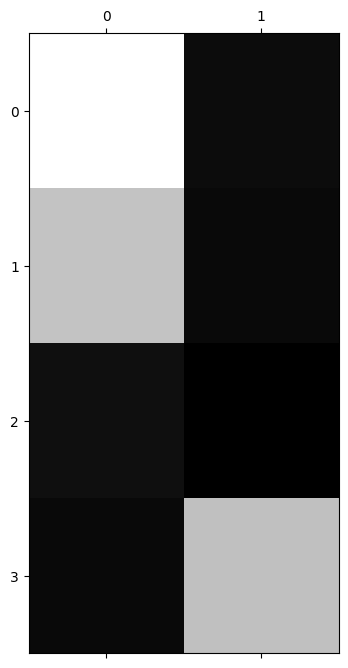

In [54]:
plt.matshow(V, cmap='gray')

Lets now put more possible states

In [55]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import copy 
import random
import pandas as pd
from tqdm import tqdm
from scipy.stats import binom
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [56]:
#from robust_q_learning_v3 import *
#from q_learning_v2 import *

In [57]:
from robust_q_learning_v2 import *
from q_learning import *

In [58]:
X = np.array([(0,0), (0,5), (0,10), (5,0), (5,5), (5,10), (10,0), (10,5), (10,10)]) # States
A = np.array([0, 5, 10]) # Actions

In [59]:
# Build the functions that allow us to get the index of an element a (reps. x) in A (resp. X)
if np.ndim(A) > 1:
    A_list = A
else:
    A_list = np.array([[a] for a in A])
if np.ndim(X) > 1:
    X_list = X
else:
    X_list = np.array([[x] for x in X])

def a_index(a):
    return np.flatnonzero((a==A_list).all(1))[0]
def x_index(x):
    return np.flatnonzero((x==X_list).all(1))[0]

In [60]:
c1 = 1 / 10

def r(x,a,y):
    x1, x2 = x
    y1, y2 = y
    return(c1 * (x2 - a >= 0) * a - 10 * (x2 - a < 0)) # Reward function

rr = 1
dr = 0
gr = 1
npp = 0
def P(x,a):
    unif      = np.random.uniform(0)
    if (unif > eps_greedy):
        x1, x2 = x
        x2_ = max(x2 - a, 0)
        y1  = min(rr * x2_ + npp * 5, 5)
        y2  = min(x2_ - 5 * dr + gr * x1, 5)
        return(y1, y2)
    else:
        return rng.choice(X)

# CREATE THE PROBABILITY MEASURE OUT OF THE RANDOM VARIABLE
nr = 1_000
p_ = np.zeros([len(X), len(A), len(X)])
for n in range(nr):
    for x in X:
        for a in A:
            y = P(x,a)
            x_ = x_index(y)
            p_[x_index(x), a_index(a), x_] += 1
p_ = p_/nr
def p(x,a,y):
    return(p_[x_index(x), a_index(a), x_index(y)])

alpha      = 0.95  # Discount Factor
x_0        = (10,10) # Initial Value
k_0        = 0     # Initial index of the corresponding MDP, starting with the central proba of 1/2
eps_greedy = 0.1   # Epsilon greedy policy

In [61]:
Nr_iter = 1_000_000

Q_0_, V = q_learning(X, A, r, P, alpha, x_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

100%|██████████| 1000000/1000000 [00:30<00:00, 33264.78it/s]


In [62]:
# Get the result of the Q-Learning algorithm,
# Get the optimal results for each x in X
def a_opt(x, Q_opt):
    return A[np.argmax(Q_opt[x_index(x),:])]

In [63]:
df = pd.DataFrame(np.array([[a_opt(x, Q_0_) for x in X]]))
df.columns = ['(0,0)', '(0,5)', '(0,10)', '(5,0)', '(5,5)', '(5,10)', '(10,0)', '(10,5)', '(10,10)']
df

,"(0,0)","(0,5)","(0,10)","(5,0)","(5,5)","(5,10)","(10,0)","(10,5)","(10,10)"
0,0,0,5,0,5,10,0,5,10


In [64]:
V

array([[287617.,  10173.,  10168.],
       [300865.,  10800.,  10810.],
       [   415.,  10388.,    410.],
       [ 10395.,    411.,    331.],
       [ 10254., 282430.,  10051.],
       [   385.,    423.,  10279.],
       [ 10476.,    380.,    403.],
       [   415.,  10297.,    382.],
       [   363.,    416.,  10263.]])

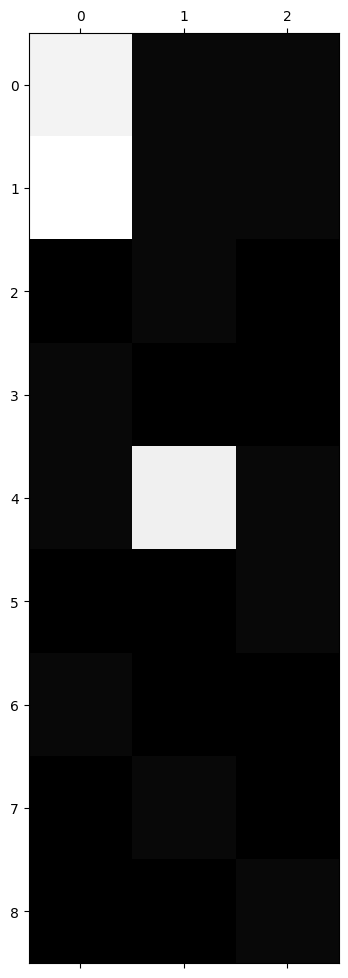

In [65]:
plt.matshow(V, cmap='gray')

Adding new transition kernels, and uncertainty

In [28]:
c1 = 1 / 10

def r(x,a,y):
    x1, x2 = x
    y1, y2 = y
    return(c1 * (x2 - a >= 0) * a - 10 * (x2 - a < 0)) # Reward function

rr = 1
dr = 0
gr = 1
npp = 0
def P1(x,a):
    unif      = np.random.uniform(0)
    if (unif > eps_greedy):
        x1, x2 = x
        x2_ = max(x2 - a, 0)
        y1  = min(rr * x2_ + npp * 5, 5)
        y2  = min(x2_ - 5 * dr + gr * x1, 5)
        return(y1, y2)
    else:
        return rng.choice(X)
    
    
eps1 = 1
npp2 = 1
def P2(x,a):
    unif      = np.random.uniform(0)
    if (unif > eps_greedy):
        x1, x2 = x
        unif2 = np.random.uniform(0)
        x2_ = max(x2 - a, 0)
        y1  = min(rr * x2_ + ((unif2 > eps1) * npp + (unif2 <= eps1) * npp2) * 5 , 5)
        y2  = min(x2_ - 5 * dr + gr * x1, 5)
        return(y1, y2)
    else:
        return rng.choice(X)

eps3 = 0.5
dr3  = 1
rr3   = 2
def P3(x,a):
    unif      = np.random.uniform(0)
    if (unif > eps_greedy):
        x1, x2 = x
        unif2 = np.random.uniform(0)
        x2_  = max(x2 - a, 0)
        y1   = min(rr3 * x2_ + npp * 5 , 10)
        x2__ = max(x2_ - ((unif2 > eps3) * dr + (unif2 <= eps3) * dr3) * 5, 0)
        y2   = min(x2__ + gr * x1, 10)
        return(y1, y2)
    else:
        return rng.choice(X)

    
# CREATE THE PROBABILITY MEASURE OUT OF THE RANDOM VARIABLE
nr = 1_000
p1_ = np.zeros([len(X), len(A), len(X)])
p2_ = np.zeros([len(X), len(A), len(X)])
p3_ = np.zeros([len(X), len(A), len(X)])
for n in range(nr):
    for x in X:
        for a in A:
            y1 = P1(x,a)
            x_1 = x_index(y1)
            p1_[x_index(x), a_index(a), x_1] += 1
            y2 = P2(x,a)
            x_2 = x_index(y2)
            p2_[x_index(x), a_index(a), x_2] += 1
            y3 = P3(x,a)
            x_3 = x_index(y3)
            p3_[x_index(x), a_index(a), x_3] += 1
p1_ = p1_/nr
p2_ = p2_/nr
p3_ = p3_/nr
def p1(x,a,y):
    return(p1_[x_index(x), a_index(a), x_index(y)])
def p2(x,a,y):
    return(p2_[x_index(x), a_index(a), x_index(y)])
def p3(x,a,y):
    return(p3_[x_index(x), a_index(a), x_index(y)])

alpha      = 0.95  # Discount Factor
x_0        = (10,10) # Initial Value
k_0        = 0     # Initial index of the corresponding MDP, starting with the central proba of 1/2
eps_greedy = 0.1   # Epsilon greedy policy

In [29]:
Nr_iter = 1_000_000
Q_0_, V = q_learning(X, A, r, P2, alpha, x_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))
df = pd.DataFrame(np.array([[a_opt(x, Q_0_) for x in X]]))
df.columns = ['(0,0)', '(0,5)', '(0,10)', '(5,0)', '(5,5)', '(5,10)', '(10,0)', '(10,5)', '(10,10)']
df

100%|██████████| 1000000/1000000 [00:31<00:00, 31606.64it/s]


,"(0,0)","(0,5)","(0,10)","(5,0)","(5,5)","(5,10)","(10,0)","(10,5)","(10,10)"
0,0,5,10,0,5,10,0,5,10


In [30]:
Nr_iter = 1_000_000
Q_opt_robust, V = robust_q_learning_v2(X, A, r, np.array([P1, P2, P3]), np.array([p1, p2, p3]), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))
df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust) for x in X]]))
df.columns = ['(0,0)', '(0,5)', '(0,10)', '(5,0)', '(5,5)', '(5,10)', '(10,0)', '(10,5)', '(10,10)']
df

100%|██████████| 1000000/1000000 [09:52<00:00, 1687.04it/s]


,"(0,0)","(0,5)","(0,10)","(5,0)","(5,5)","(5,10)","(10,0)","(10,5)","(10,10)"
0,0,5,10,0,5,10,0,5,10


Now lets add a new species to simulate the willingness to keep a certain biodiversity

In [31]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import copy 
import random
import pandas as pd
from tqdm import tqdm
from scipy.stats import binom
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
#from robust_q_learning_v3 import *
#from q_learning_v2 import *

In [32]:
from robust_q_learning_v2 import *
from q_learning import *

In [33]:
A_s1 = np.array([0, 5]) # Actions
X    = []
for x1 in A_s1:
    for x2 in A_s1:
        X += [(x1, x2)]
X_s1 = np.array(X) # States

A_s2 = np.array([0, 5, 10]) # Actions
X    = []
for x1 in A_s2:
    for x2 in A_s2:
        X += [(x1, x2)]
X_s2 = np.array(X) # States

A = []
for a1 in A_s1:
    for a2 in A_s2:
        A += [(a1, a2)]
A = np.array(A) # Actions
X = []
for x1 in X_s1:
    for x2 in X_s2:
        X += [(x1, x2)]
X = np.array(X) # States

In [34]:
# Build the functions that allow us to get the index of an element a (reps. x) in A (resp. X)
if np.ndim(A) > 1:
    A_list = A
else:
    A_list = np.array([[a] for a in A])
if np.ndim(X) > 1:
    X_list = X
else:
    X_list = np.array([[x] for x in X])

def a_index(a):
    return np.flatnonzero((a==A_list).all(1))[0]
def x_index(x):
    return np.flatnonzero((x==X_list).all(1))[0]

In [35]:
c1 = 2 / 5 
c2 = 1 / 10 
psy  = 1

def r(x,a,y):
    x_s1, x_s2   = x
    y_s1, y_s2   = y
    x1_s1, x2_s1 = x_s1
    x1_s2, x2_s2 = x_s2
    y1_s1, y2_s1 = y_s1
    y1_s2, y2_s2 = y_s2
    a_s1, a_s2   = a

    food_s1      = c1 * (x2_s1 - a_s1 >= 0) * a_s1 - 10 * (x2_s1 - a_s1 < 0)  #Optimization term, regarding the food that the species 1 can give us
    food_s2      = c2 * (x2_s2 - a_s2 >= 0) * a_s2 - 10 * (x2_s2 - a_s2 < 0)  #Optimization term, regarding the food that the species 2 can give us
    biod         = psy  * (y1_s1 + y2_s1 > 0) * (y1_s2 + y2_s2 > 0)           #Optimization term, regarding the biodiversity we want to keep
    return(food_s1 + food_s2 + biod) # Reward function

rr = 1
dr = 0
gr = 1
npp = 0
def P(x,a):
    unif      = np.random.uniform(0)
    if (unif > eps_greedy):
        x_s1, x_s2   = x
        x1_s1, x2_s1 = x_s1
        x1_s2, x2_s2 = x_s2
        a_s1, a_s2   = a 
        
        x2_s1_ = max(x2_s1 - a_s1, 0)
        y1_s1  = min(rr * x2_s1_ + npp * 5, 5)
        y2_s1  = min(x2_s1_ - 5 * dr + gr * x1_s1, 5)
        
        x2_s2_ = max(x2_s2 - a_s2, 0)
        y1_s2  = min(rr * x2_s2_ + npp * 5, 10)
        y2_s2  = min(x2_s2_ - 5 * dr + gr * x1_s2, 10)
        
        return ((y1_s1, y2_s1), (y1_s2, y2_s2))
    else:
        return rng.choice(X)

# CREATE THE PROBABILITY MEASURE OUT OF THE RANDOM VARIABLE
nr = 1_000
p_ = np.zeros([len(X), len(A), len(X)])
for n in range(nr):
    for x in X:
        for a in A:
            y = P(x,a)
            x_ = x_index(y)
            p_[x_index(x), a_index(a), x_] += 1
p_ = p_/nr
def p(x,a,y):
    return(p_[x_index(x), a_index(a), x_index(y)])

alpha      = 0.95  # Discount Factor
x_0        = ((5, 5), (10, 10)) # Initial Value
k_0        = 0     # Initial index of the corresponding MDP, starting with the central proba of 1/2
eps_greedy = 0.1   # Epsilon greedy policy

In [36]:
Nr_iter = 1_000_000

Q_0_, V = q_learning(X, A, r, P, alpha, x_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [00:47<00:00, 20941.66it/s]


In [37]:
# Get the result of the Q-Learning algorithm,
# Get the optimal results for each x in X
def a_opt(x, Q_opt):
    return A[np.argmax(Q_opt[x_index(x),:])]

In [38]:
Result = np.array([[a_opt(x, Q_0_) for x in X]])
Result = Result[0]

In [39]:
pd.set_option('display.max_columns', None)

In [40]:

df = pd.DataFrame(Result.T)
df.columns = pd.MultiIndex.from_tuples([(str(x[0]).replace("[", "(").replace("]", ")"), str(x[1]).replace("[", "(").replace("]", ")")) for x in X]) #[str(x) for x in X]
df.index.name = "Species"
df.columns.names = ["A", "B"]
df

A       (0 0)                                                           (0 5)  \
B       (0 0) (0 5) ( 0 10) (5 0) (5 5) ( 5 10) (10  0) (10  5) (10 10) (0 0)   
Species                                                                         
0           0     0       0     0     0       0       0       0       0     0   
1           0     0       0     0     5       5       0       5       5     0   

A                                                                 (5 0)        \
B       (0 5) ( 0 10) (5 0) (5 5) ( 5 10) (10  0) (10  5) (10 10) (0 0) (0 5)   
Species                                                                         
0           0       0     0     0       0       0       0       0     0     0   
1           0       0     5     5       5       0       0       0     0     5   

A                                                           (5 5)        \
B       ( 0 10) (5 0) (5 5) ( 5 10) (10  0) (10  5) (10 10) (0 0) (0 5)   
Species                                                                   
0             0     0     0       0       0       0       0     5     5   
1             5     0     5       5       0       5       5     0     0   

A                                                            
B       ( 0 10) (5 0) (5 5) ( 5 10) (10  0) (10  5) (10 10)  
Species                                                      
0             5     5     5       5       5       5       5  
1             5     0     0       5       0       0       5

In [11]:
#df.to_csv("df_bio1_nonrobust.csv")

In [41]:
V

array([[2.54491e+05, 4.70600e+03, 4.59700e+03, 4.59700e+03, 4.70700e+03,
        4.72800e+03],
       [1.26010e+04, 2.19000e+02, 2.32000e+02, 2.24000e+02, 2.37000e+02,
        2.18000e+02],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [2.08000e+03, 6.28310e+04, 1.22600e+03, 1.17000e+03, 1.12700e+03,
        1.16800e+03],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [2.29100e+03, 1.10057e+05, 1.92240e+04, 2.31100e+03, 2.33200e+03,
        2.36200e+03],
       [5.77900e+03, 1.79410e+05, 3.34800e+03, 3.41600e+03, 3.43300e+03,
        3.37700e+03],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.0

In [42]:
Q_opt_robust, V = robust_q_learning_v2(X, A, r, np.array([P]), np.array([p]), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

  0%|          | 102/1000000 [00:00<16:29, 1010.96it/s]

100%|██████████| 1000000/1000000 [17:12<00:00, 968.57it/s]


In [43]:
Result_r = np.array([[a_opt(x, Q_opt_robust) for x in X]])
Result_r = Result_r[0]

In [44]:
df = pd.DataFrame(Result.T)
df.columns = pd.MultiIndex.from_tuples([(str(x[0]).replace("[", "(").replace("]", ")"), str(x[1]).replace("[", "(").replace("]", ")")) for x in X]) #[str(x) for x in X]
df.index.name = "Species"
df.columns.names = ["A", "B"]
df

A       (0 0)                                                           (0 5)  \
B       (0 0) (0 5) ( 0 10) (5 0) (5 5) ( 5 10) (10  0) (10  5) (10 10) (0 0)   
Species                                                                         
0           0     0       0     0     0       0       0       0       0     0   
1           0     0       0     0     5       5       0       5       5     0   

A                                                                 (5 0)        \
B       (0 5) ( 0 10) (5 0) (5 5) ( 5 10) (10  0) (10  5) (10 10) (0 0) (0 5)   
Species                                                                         
0           0       0     0     0       0       0       0       0     0     0   
1           0       0     5     5       5       0       0       0     0     5   

A                                                           (5 5)        \
B       ( 0 10) (5 0) (5 5) ( 5 10) (10  0) (10  5) (10 10) (0 0) (0 5)   
Species                                                                   
0             0     0     0       0       0       0       0     5     5   
1             5     0     5       5       0       5       5     0     0   

A                                                            
B       ( 0 10) (5 0) (5 5) ( 5 10) (10  0) (10  5) (10 10)  
Species                                                      
0             5     5     5       5       5       5       5  
1             5     0     0       5       0       0       5

In [45]:
#df.to_csv("df_bio1_robust.csv")

In [46]:
V

array([[1.90392e+05, 3.42500e+03, 3.36500e+03, 3.45700e+03, 3.50600e+03,
        3.47000e+03],
       [1.28020e+04, 2.59000e+02, 2.06000e+02, 2.49000e+02, 2.42000e+02,
        2.47000e+02],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [1.98920e+04, 1.90340e+04, 6.78000e+02, 6.41000e+02, 7.37000e+02,
        6.69000e+02],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [3.33460e+04, 1.59266e+05, 1.75300e+04, 3.66600e+03, 3.71300e+03,
        3.72400e+03],
       [1.05190e+04, 1.85246e+05, 3.41900e+03, 3.49800e+03, 3.38100e+03,
        3.57900e+03],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.0